In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import statsmodels.formula.api as smf
from sklearn import linear_model, datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.utils import resample
from sklearn import cross_validation as cv
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from tabulate import tabulate
from sklearn.base import TransformerMixin

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from IPython.core.debugger import Tracer; debug_here = Tracer()
#debug_here()

In [3]:
df = pd.read_csv('risk_factors_cervical_cancer.csv')
# df.head()
print(df.shape)

(858, 36)


In [4]:
df.columns = df.columns.str.replace('\s+', '_')
df.columns = df.columns.str.replace(':', '')
df.columns = df.columns.str.replace('(', '')
df.columns = df.columns.str.replace(')', '')
df.columns = df.columns.str.replace('/', 'Per')
df.columns = df.columns.str.replace('-', 'min')

df=df.replace("?", np.NaN)
df.head()

,Age,Number_of_sexual_partners,First_sexual_intercourse,Num_of_pregnancies,Smokes,Smokes_years,Smokes_packsPeryear,Hormonal_Contraceptives,Hormonal_Contraceptives_years,IUD,...,STDs_Time_since_first_diagnosis,STDs_Time_since_last_diagnosis,DxCancer,DxCIN,DxHPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
2,34,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,NaN,NaN,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0


In [5]:
df.isnull().sum()

Age                                      0
Number_of_sexual_partners               26
First_sexual_intercourse                 7
Num_of_pregnancies                      56
Smokes                                  13
Smokes_years                            13
Smokes_packsPeryear                     13
Hormonal_Contraceptives                108
Hormonal_Contraceptives_years          108
IUD                                    117
IUD_years                              117
STDs                                   105
STDs_number                            105
STDscondylomatosis                     105
STDscervical_condylomatosis            105
STDsvaginal_condylomatosis             105
STDsvulvominperineal_condylomatosis    105
STDssyphilis                           105
STDspelvic_inflammatory_disease        105
STDsgenital_herpes                     105
STDsmolluscum_contagiosum              105
STDsAIDS                               105
STDsHIV                                105
STDsHepatit

Since time since STD diagnoses features have too much missing data, we will delete these features altogether. We will drop 'STDs_Time_since_first_diagnosis' and 'STDs_Time_since_last_diagnosis'.

In [6]:
print(df['STDsAIDS'].sum())
print(df['Citology'].sum())
print(df['Schiller'].sum())
print(df['STDscervical_condylomatosis'].sum())

0.0
44
74
0.0


In [7]:
df.drop('STDs_Time_since_last_diagnosis', 1, inplace=True)
df.drop('STDs_Time_since_first_diagnosis', 1, inplace=True)

# drop columns with sum=0
df.drop('STDscervical_condylomatosis', 1, inplace=True)
df.drop('STDsAIDS', 1, inplace=True)


df.drop('Citology', 1, inplace=True)
df.drop('Schiller', 1, inplace=True)
df.drop('Hinselmann', 1, inplace=True)

df.dropna(axis=1, thresh=800, inplace=True)


print(len(df.columns))
print(df.columns)

13
Index(['Age', 'Number_of_sexual_partners', 'First_sexual_intercourse',
       'Num_of_pregnancies', 'Smokes', 'Smokes_years', 'Smokes_packsPeryear',
       'STDs_Number_of_diagnosis', 'DxCancer', 'DxCIN', 'DxHPV', 'Dx',
       'Biopsy'],
      dtype='object')


In [8]:
df.dropna(how='all', inplace=True) #drop rows where all columns are NaN
df.shape

(858, 13)

Impute missing values using mean imputation

In [9]:
class DataFrameImputer(TransformerMixin):
    def __init__(self):
        imr = Imputer(missing_values='NaN', strategy='most_frequent', axis=0).fit(df) #calculate column means, most frequent strategy because best when dealing with categorical data
        imputed_data = imr.transform(df.values)
     
    def fit(self, temp, y=None):
        self.fill = pd.Series([temp[c].value_counts().index[0]
            if temp[c].dtype == np.dtype('O') else temp[c].mean() for c in temp],
            index = temp.columns)
        
        return self
    
    def transform(self, temp, y=None):
        return temp.fillna(self.fill)

temp = pd.DataFrame(df)
temp_T = DataFrameImputer().fit_transform(temp)
temp_T.head()

,Age,Number_of_sexual_partners,First_sexual_intercourse,Num_of_pregnancies,Smokes,Smokes_years,Smokes_packsPeryear,STDs_Number_of_diagnosis,DxCancer,DxCIN,DxHPV,Dx,Biopsy
0,18,4.0,15.0000,1.0,0.0,0.0,0.0,0,0,0,0,0,0
1,15,1.0,14.0000,1.0,0.0,0.0,0.0,0,0,0,0,0,0
2,34,1.0,16.9953,1.0,0.0,0.0,0.0,0,0,0,0,0,0
3,52,5.0,16.0000,4.0,1.0,37.0,37.0,0,1,0,1,0,0
4,46,3.0,21.0000,4.0,0.0,0.0,0.0,0,0,0,0,0,0


In [10]:
df = temp_T
# df.head()
print(df.isnull().sum())
print(df.shape)

Age                          0
Number_of_sexual_partners    0
First_sexual_intercourse     0
Num_of_pregnancies           0
Smokes                       0
Smokes_years                 0
Smokes_packsPeryear          0
STDs_Number_of_diagnosis     0
DxCancer                     0
DxCIN                        0
DxHPV                        0
Dx                           0
Biopsy                       0
dtype: int64
(858, 13)


In [11]:
# Find predictors where variance is 0

new_df= df.describe()
new_df.loc['std']==0

Age                          False
Number_of_sexual_partners    False
First_sexual_intercourse     False
Num_of_pregnancies           False
Smokes                       False
Smokes_years                 False
Smokes_packsPeryear          False
STDs_Number_of_diagnosis     False
DxCancer                     False
DxCIN                        False
DxHPV                        False
Dx                           False
Biopsy                       False
Name: std, dtype: bool

# Forward Selection: Control Set

In [15]:
#Check which columns have 0 variance
df1 = df.loc[df.loc[df.Biopsy==0].head(55).index]
df2 = df.loc[df.loc[df.Biopsy==1].head(100).index]
frames = [df1, df2]
new_df = pd.concat(frames)

x_cols = [col for col in new_df.columns if col not in ['Biopsy']]

# for x_col in x_cols:
#     print(new_df[x_col].var())

new_df.drop('Dx', 1, inplace=True)
new_df.drop('DxHPV', 1, inplace=True)
new_df.drop('DxCIN', 1, inplace=True)
new_df.drop('DxCancer', 1, inplace=True)
new_df.drop('STDs_Number_of_diagnosis', 1, inplace=True)
x_cols = [col for col in new_df.columns if col not in ['Biopsy']]
x_cols

['Age',
 'Number_of_sexual_partners',
 'First_sexual_intercourse',
 'Num_of_pregnancies',
 'Smokes',
 'Smokes_years',
 'Smokes_packsPeryear']

Biopsy ~ 1 + Age + Smokes_years
MSE for control:  0.168660625227
Controlled Data: Forward Selection Confusion matrix: 
 [[49  6]
 [15 40]]
Sensitivity:  0.727272727273
Specificity:  0.890909090909
0.809090909091 

   Accuracy           Analysis  Sensitivity  Specificity
0  0.809091  Forward Selection     0.727273     0.890909 




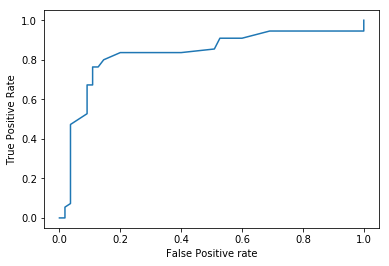

In [16]:
#forward selection of controlled dataset
import warnings
def ignore_warning():
    warnings.warn('ignoring warning')

    
control = []

# x_cols = [col for col in new_df.columns if col not in ['Biopsy']]
final = []
kf = KFold(n_splits=10, shuffle=True)
new_df[x_cols]
formula = 'Biopsy ~ 1'
for i in range(len(x_cols)):
    mse_info = []
    
    for x_col in x_cols:
        formula_try = (formula + ' + ' + x_col)
#         print(x_col)
        res_logit = smf.logit(formula=formula_try, data=new_df).fit(disp=0)
        
        
        y_pred = res_logit.predict(new_df)
        y = new_df.Biopsy 
        diff = y_pred - y
        mse = (np.dot(diff, diff))/len(diff)
        
        mse_info.append({'predictor': x_col,
                        'MSE': mse})
    
    mse_info = pd.DataFrame(mse_info)
    selected_col = mse_info.loc[mse_info.MSE.argmin(axis=0), 'predictor']
    
    formula = (formula + ' + ' + selected_col)
    x_cols.remove(selected_col)
    
    train_info = []
    test_info = []
    for train_i, test_i in kf.split(new_df):
        df_train = new_df.iloc[train_i, :]
        df_test = new_df.iloc[test_i, :]
        
        res_logit = smf.logit(formula=formula, data=df_train).fit(disp=0)
        
        #Train MSE
        y_pred = res_logit.predict(df_train)
        y = df_train.Biopsy
        diff = y_pred - y
        train_mse = (np.dot(diff, diff))/len(diff)
        
        #Test MSE 
        y_pred = res_logit.predict(df_test)
        y = df_test.Biopsy
        diff = y_pred - y
        test_mse = (np.dot(diff, diff)/len(diff))
        
        train_info.append(train_mse)
        test_info.append(test_mse)
        
    train_mse = np.mean(train_info)
    test_mse = np.mean(test_info)
    final.append({'step': i,
                 'formula': formula,
                 'train_mse': train_mse,
                 'test_mse': test_mse})

final = pd.DataFrame(final)

#find best formula
final_formula_fwd = final.loc[final.test_mse.argmin(), 'formula']
print(final_formula_fwd)
print('MSE for control: ', final.loc[final.test_mse.argmin(), 'test_mse'])
best_logit = smf.logit(formula=final_formula_fwd, data=new_df).fit(disp=0)

#fit with new formula
new_df.Biopsy_pred = best_logit.predict(new_df) 
new_df.Biopsy_pred_cat = pd.cut(new_df.Biopsy_pred, [0, .5, 1], labels = [0, 1])
conf_mat = confusion_matrix(new_df.Biopsy, new_df.Biopsy_pred_cat)



print('Controlled Data: Forward Selection Confusion matrix: \n', conf_mat)
fwd_sensitivity = conf_mat[1,1]/(conf_mat[1,0] + conf_mat[1,1])
print('Sensitivity: ', fwd_sensitivity)
fwd_specificity = conf_mat[0,0]/(conf_mat[0,0] + conf_mat[0,1])
print('Specificity: ', fwd_specificity)
fwd_accuracy = (conf_mat[0,0]+conf_mat[1,1])/(conf_mat[0,0]+conf_mat[0,1]+conf_mat[1,0]+conf_mat[1,1])
control.append({'Analysis': 'Forward Selection',
               'Sensitivity': fwd_sensitivity,
               'Specificity': fwd_specificity,
               'Accuracy': fwd_accuracy})

print(fwd_accuracy, '\n')




df_control = pd.DataFrame(control)
print(df_control, '\n\n')
# print("success!!!")


"""
ROC curve
"""
thresholds = np.arange(0, 1, 0.01)
res_list = []
fpr_list = []
tpr_list = []

for threshold in thresholds:
    pred_cat = (best_logit.predict(new_df[['Age', 'Smokes_years',  'Smokes_packsPeryear']]) > threshold)*1
    conf_mat = confusion_matrix(new_df.Biopsy, pred_cat)

    specificity = conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
    sensitivity = conf_mat[1,1]/(conf_mat[1,0]+conf_mat[1,1])
    fpr = 1 - specificity
    tpr = sensitivity
    trr = (conf_mat[1,0]+conf_mat[0,1])/(conf_mat[1,0]+conf_mat[0,0]+conf_mat[0,1]+conf_mat[1,1])
    
    res_list.append({'Threshold': threshold,
                      'Specificity': specificity, 
                      'Sensitivity': sensitivity, 
                      'FPR': fpr,
                      'TPR': tpr,
                      'TRR': trr})
    fpr_list.append(fpr)
    tpr_list.append(tpr)

df_res = pd.DataFrame(res_list)
plt.plot(df_res.FPR, df_res.TPR)
plt.xlabel('False Positive rate')
plt.ylabel('True Positive Rate')
plt.show()

In [200]:
fwd_acc_control = fwd_accuracy
fwd_mse_control = final.loc[final.test_mse.argmin(), 'test_mse']
fwd_sensitivity_control = fwd_sensitivity
fwd_specificity_control = fwd_specificity

In [201]:
control = []

#Forward Selection
# results = smf.logit(formula=final_formula_fwd, data=df).fit(disp=0)
df1 = df.loc[df.loc[df.Biopsy==0].head(55).index]
df2 = df.loc[df.loc[df.Biopsy==1].head(55).index]
frames = [df1, df2]
new_df = pd.concat(frames)
new_df2 = new_df


results = smf.logit(formula=final_formula_fwd, data=new_df).fit(disp=0)

new_df.Biopsy_pred = results.predict(new_df) #keep all biopsy==1 and 55 controls (biopsy==0)
new_df.Biopsy_pred_cat = pd.cut(new_df.Biopsy_pred, [0, .5, 1], labels = [0, 1])
conf_mat = confusion_matrix(new_df.Biopsy, new_df.Biopsy_pred_cat)

print('Controlled Data: Forward Selection Confusion matrix: \n', conf_mat)
fwd_sensitivity = conf_mat[1,1]/(conf_mat[1,0] + conf_mat[1,1])
print('Sensitivity: ', fwd_sensitivity)
fwd_specificity = conf_mat[0,0]/(conf_mat[0,0] + conf_mat[0,1])
print('Specificity: ', fwd_specificity)
fwd_accuracy = (conf_mat[0,0]+conf_mat[1,1])/(conf_mat[0,0]+conf_mat[0,1]+conf_mat[1,0]+conf_mat[1,1])
control.append({'Analysis': 'Forward Selection',
               'Sensitivity': fwd_sensitivity,
               'Specificity': fwd_specificity,
               'Accuracy': fwd_accuracy})

print(fwd_accuracy, '\n')




df_control = pd.DataFrame(control)
print(df_control)

Controlled Data: Forward Selection Confusion matrix: 
 [[50  5]
 [15 40]]
Sensitivity:  0.727272727273
Specificity:  0.909090909091
0.818181818182 

   Accuracy           Analysis  Sensitivity  Specificity
0  0.818182  Forward Selection     0.727273     0.909091


# Forward selection: Whole dataset 


In [151]:
#forward-selection
import warnings
def ignore_warning():
    warnings.warn('ignoring warning')

warnings.filterwarnings("ignore")
ignore_warning()


x_cols = [col for col in df.columns if col not in ['Biopsy']]
final = []
kf = KFold(n_splits=50, shuffle=True)

formula = 'Biopsy ~ 1'
for i in range(len(x_cols)):
    mse_info = []
    
    for x_col in x_cols:
        formula_try = (formula + ' + ' + x_col)
#         print(x_col)
        res_logit = smf.logit(formula=formula_try, data=df).fit(disp=0)
        
        
        y_pred = res_logit.predict(df)
        y = df.Biopsy 
        diff = y_pred - y
        mse = (np.dot(diff, diff))/len(diff)
        
        mse_info.append({'predictor': x_col,
                        'MSE': mse})
    
    mse_info = pd.DataFrame(mse_info)
    selected_col = mse_info.loc[mse_info.MSE.argmin(axis=0), 'predictor']
    
    formula = (formula + ' + ' + selected_col)
    x_cols.remove(selected_col)
    
    train_info = []
    test_info = []
    for train_i, test_i in kf.split(df):
        df_train = df.iloc[train_i, :]
        df_test = df.iloc[test_i, :]
        
        res_logit = smf.logit(formula=formula, data=df_train).fit(disp=0)
        
        #Train MSE
        y_pred = res_logit.predict(df_train)
        y = df_train.Biopsy
        diff = y_pred - y
        train_mse = (np.dot(diff, diff))/len(diff)
        
        #Test MSE 
        y_pred = res_logit.predict(df_test)
        y = df_test.Biopsy
        diff = y_pred - y
        test_mse = (np.dot(diff, diff)/len(diff))
        
        train_info.append(train_mse)
        test_info.append(test_mse)
        
    train_mse = np.mean(train_info)
    test_mse = np.mean(test_info)
    final.append({'step': i,
                 'formula': formula,
                 'train_mse': train_mse,
                 'test_mse': test_mse})

final = pd.DataFrame(final)
final

,formula,step,test_mse,train_mse
0,Biopsy ~ 1 + DxCancer,0,0.058850,0.058434
1,Biopsy ~ 1 + DxCancer + DxCIN,1,0.058662,0.057628
2,Biopsy ~ 1 + DxCancer + DxCIN + STDs_Number_of...,2,0.059118,0.057260
3,Biopsy ~ 1 + DxCancer + DxCIN + STDs_Number_of...,3,0.059933,0.057050
4,Biopsy ~ 1 + DxCancer + DxCIN + STDs_Number_of...,4,0.059126,0.056926
5,Biopsy ~ 1 + DxCancer + DxCIN + STDs_Number_of...,5,0.059187,0.056803
6,Biopsy ~ 1 + DxCancer + DxCIN + STDs_Number_of...,6,0.060512,0.056750
7,Biopsy ~ 1 + DxCancer + DxCIN + STDs_Number_of...,7,0.060690,0.056239
8,Biopsy ~ 1 + DxCancer + DxCIN + STDs_Number_of...,8,0.060317,0.056218
9,Biopsy ~ 1 + DxCancer + DxCIN + STDs_Number_of...,9,0.061446,0.056209


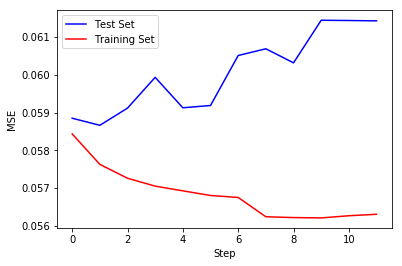

In [152]:
plt.plot(final.step, final.test_mse, label='Test Set', c='blue')
plt.plot(final.step, final.train_mse, label='Training Set', c='red')
plt.xlabel('Step')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [153]:
print(final.loc[final.test_mse.argmin()])
final_formula_fwd = final.loc[final.test_mse.argmin(), 'formula']
print(final_formula_fwd)

formula      Biopsy ~ 1 + DxCancer + DxCIN
step                                     1
test_mse                         0.0586621
train_mse                        0.0576277
Name: 1, dtype: object
Biopsy ~ 1 + DxCancer + DxCIN


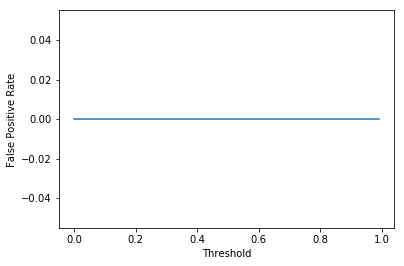

In [44]:
# ROC plot
res_logit = smf.logit(formula=final_formula_fwd, data=df).fit(disp=0)
thresholds = np.arange(0, 1, 0.01)
res_list = []
fpr_list = []
tpr_list = []

for threshold in thresholds:
    
    pred_cat = (res_logit.predict(df[['DxCancer', 'DxCIN', 'STDs_Number_of_diagnosis']]) > 1)*1
    conf_mat = confusion_matrix(df.Biopsy, pred_cat)
    
    specificity = conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
    sensitivity = conf_mat[1,1]/(conf_mat[1,0]+conf_mat[1,1])
    fpr = 1 - specificity
    tpr = sensitivity
    trr = (conf_mat[1,0]+conf_mat[0,1])/(conf_mat[1,0]+conf_mat[0,0]+conf_mat[0,1]+conf_mat[1,1])
    
    res_list.append({'Threshold': threshold,
                      'Specificity': specificity, 
                      'Sensitivity': sensitivity, 
                      'FPR': fpr,
                      'TPR': tpr,
                      'TRR': trr})
    fpr_list.append(fpr)
    tpr_list.append(tpr)

df_res = pd.DataFrame(res_list)
plt.plot(df_res.Threshold, df_res.FPR)
plt.xlabel('Threshold')
plt.ylabel('False Positive Rate')
plt.show()

res_df = pd.DataFrame(res_list)
# print(res_df.FPR.sum())

In [154]:
res=[]

df.Biopsy_pred = res_logit.predict(df) 
df.Biopsy_pred_cat = pd.cut(df.Biopsy_pred, [0, .5, 1], labels = [0, 1])
conf_mat = confusion_matrix(df.Biopsy, df.Biopsy_pred_cat)

print('Whole Data: Forward Selection Confusion matrix: \n', conf_mat)
fwd_sensitivity = conf_mat[1,1]/(conf_mat[1,0] + conf_mat[1,1])
print('Sensitivity: ', fwd_sensitivity)
fwd_specificity = conf_mat[0,0]/(conf_mat[0,0] + conf_mat[0,1])
print('Specificity: ', fwd_specificity)
fwd_accuracy = (conf_mat[0,0]+conf_mat[1,1])/(conf_mat[0,0]+conf_mat[0,1]+conf_mat[1,0]+conf_mat[1,1])
res.append({'Analysis': 'Forward Selection',
               'Sensitivity': fwd_sensitivity,
               'Specificity': fwd_specificity,
               'Accuracy': fwd_accuracy})

print(fwd_accuracy, '\n')


df_control = pd.DataFrame(res)
print(df_control)

Whole Data: Forward Selection Confusion matrix: 
 [[801   2]
 [ 52   3]]
Sensitivity:  0.0545454545455
Specificity:  0.997509339975
0.937062937063 

   Accuracy           Analysis  Sensitivity  Specificity
0  0.937063  Forward Selection     0.054545     0.997509


In [158]:
fwd_acc_whole = fwd_accuracy
fwd_mse_whole = final.loc[final.test_mse.argmin(), 'test_mse']
fwd_sensitivity_whole = fwd_sensitivity
fwd_specificity_whole = fwd_specificity

# Principal Component Regression: Whole dataset

In [159]:
df.columns = df.columns.str.replace('\s+', '_')
predictors = [col for col in df.columns if col not in ['Biopsy']]

pred_i = [([np.arange(1, len(predictors)+1, 1)])]

In [160]:
X = df[predictors].values.T
n_i, n_j = X.shape

stds = np.std(X, axis=1)
stds=np.repeat(np.reshape(stds, (-1,1)), n_j, axis=1)
S = X/stds
# print(np.std(S, axis=1))

In [163]:
mean_mses=[]
kf=KFold(n_splits=50, shuffle=True)
pc_nums = [i+1 for i in range(5)]

pcs = PCA(n_components=5).fit_transform(S.T)
df_pcs = pd.DataFrame(pcs, columns=['PC'+str(i+1) for i in range(5)])
df_pcs['Biopsy'] = df.Biopsy.values


for pc_i in pc_nums:
    train_mses = []
    test_mses = []
    
    for train_i, test_i in kf.split(df_pcs):
        df_train = df_pcs.iloc[train_i, :]
        df_test = df_pcs.iloc[test_i, :]
        
        formula = 'Biopsy ~ 1'
        for i in range(1, pc_i+1):
            formula += (' + PC%d' % i)
        
        res_logit = smf.logit(formula=formula, data=df_train).fit(disp=0)
        
        #MSE train
        train_pred = res_logit.predict(df_train)
        mse_train = np.mean((train_pred - df_train.Biopsy)**2)
        train_mses.append(mse_train)
        
        #MSE test
        test_pred = res_logit.predict(df_test)
        mse_test = np.mean((test_pred - df_test.Biopsy)**2)
        test_mses.append(mse_test)
    
    mean_train_mse = np.mean(train_mses)
    mean_test_mse = np.mean(test_mses)
    
    mean_mses.append({'pc_i': pc_i,
                     'formula': formula,
                     'mean_train_mse': mean_train_mse,
                     'mean_test_mse': mean_test_mse})

df_result = pd.DataFrame(mean_mses)
df_result

,formula,mean_test_mse,mean_train_mse,pc_i
0,Biopsy ~ 1 + PC1,0.059309,0.058741,1
1,Biopsy ~ 1 + PC1 + PC2,0.059188,0.058349,2
2,Biopsy ~ 1 + PC1 + PC2 + PC3,0.059984,0.058353,3
3,Biopsy ~ 1 + PC1 + PC2 + PC3 + PC4,0.060581,0.058130,4
4,Biopsy ~ 1 + PC1 + PC2 + PC3 + PC4 + PC5,0.060267,0.058143,5


In [164]:
best = df_result.loc[df_result.mean_test_mse.argmin()]
best
final_formula_pc = df_result.loc[df_result.mean_test_mse.argmin(), 'formula']
final_formula_pc

'Biopsy ~ 1 + PC1 + PC2'

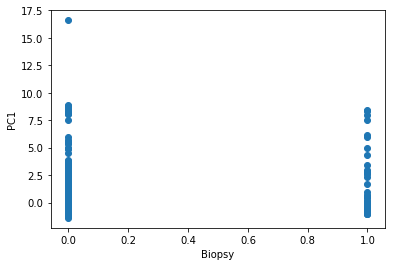

In [165]:
PC1 = pcs[:,0]
plt.scatter(df.Biopsy, PC1)
plt.xlabel('Biopsy')
plt.ylabel('PC1')
plt.show()

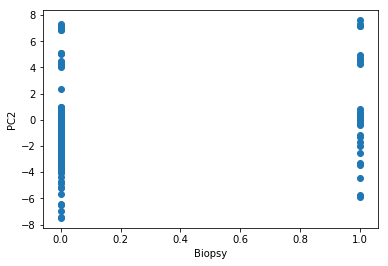

In [166]:
PC2 = pcs[:,1]
plt.scatter(df.Biopsy, PC2)
plt.xlabel('Biopsy')
plt.ylabel('PC2')
plt.show()

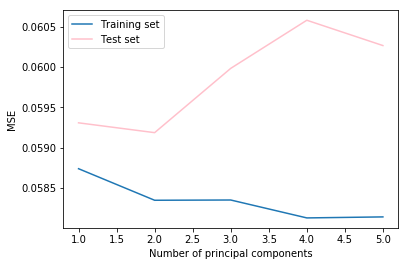

In [168]:
plt.plot(df_result.pc_i, df_result.mean_train_mse, label='Training set')
plt.plot(df_result.pc_i, df_result.mean_test_mse, label='Test set', color='pink')

plt.xlabel('Number of principal components')
plt.ylabel('MSE')
plt.legend()
plt.show()


In [170]:
results = smf.logit(formula=final_formula_pc, data=df).fit(disp=0)
df.Biopsy_pred = results.predict(df)
df.Biopsy_pred_cat = pd.cut(df.Biopsy_pred, [0, .5, 1], labels = [0, 1])
conf_mat = confusion_matrix(df.Biopsy, df.Biopsy_pred_cat)


print('Principal Component Confusion matrix: \n', conf_mat)
pc_sensitivity_whole = conf_mat[1,1]/(conf_mat[1,0] + conf_mat[1,1])
print('Sensitivity: ', pc_sensitivity_whole)
pc_specificity_whole = conf_mat[0,0]/(conf_mat[0,0] + conf_mat[0,1])
print('Specificity: ', pc_specificity_whole)
pc_accuracy_whole = (conf_mat[0,0]+conf_mat[1,1])/(conf_mat[0,0]+conf_mat[0,1]+conf_mat[1,0]+conf_mat[1,1])

print('Accuracy:', pc_accuracy_whole)

Principal Component Confusion matrix: 
 [[802   1]
 [ 55   0]]
Sensitivity:  0.0
Specificity:  0.998754669988
Accuracy: 0.934731934732


In [177]:
pc_mse_whole = df_result.loc[df_result.mean_test_mse.argmin(), 'mean_test_mse']

# Principal Component Analysis: Controlled

In [178]:
#Check which columns have 0 variance
df1 = df.loc[df.loc[df.Biopsy==0].head(55).index]
df2 = df.loc[df.loc[df.Biopsy==1].head(100).index]
frames = [df1, df2]
new_df = pd.concat(frames)

x_cols = [col for col in new_df.columns if col not in ['Biopsy']]

for x_col in x_cols:
    print(x_col + ": ", new_df[x_col].var())

new_df.drop('Dx', 1, inplace=True)
new_df.drop('DxHPV', 1, inplace=True)
new_df.drop('DxCIN', 1, inplace=True)
new_df.drop('DxCancer', 1, inplace=True)
new_df.drop('STDs_Number_of_diagnosis', 1, inplace=True)
x_cols = [col for col in new_df.columns if col not in ['Biopsy']]
x_cols

X = new_df[x_cols].values.T
n_i, n_j = X.shape

stds = np.std(X, axis=1)
stds=np.repeat(np.reshape(stds, (-1,1)), n_j, axis=1)
S = X/stds
# print(np.std(S, axis=1))

Age:  79.4265221018
Number_of_sexual_partners:  1.46360198977
First_sexual_intercourse:  9.4953994221
Num_of_pregnancies:  2.05595134375
Smokes:  0.131416051312
Smokes_years:  34.6505892921
Smokes_packsPeryear:  15.5335303652
STDs_Number_of_diagnosis:  0.105170975813
DxCancer:  0.0680567139283
DxCIN:  0.0267723102585
DxHPV:  0.0680567139283
Dx:  0.0680567139283


In [181]:
mean_mses=[]
kf=KFold(n_splits=50, shuffle=True)
pc_nums = [i+1 for i in range(5)]

pcs = PCA(n_components=5).fit_transform(S.T)
new_df_pcs = pd.DataFrame(pcs, columns=['PC'+str(i+1) for i in range(5)])
new_df_pcs['Biopsy'] = new_df.Biopsy.values



for pc_i in pc_nums:
    train_mses = []
    test_mses = []
    
    for train_i, test_i in kf.split(new_df_pcs):
        df_train = new_df_pcs.iloc[train_i, :]
        df_test = new_df_pcs.iloc[test_i, :]
        
        formula = 'Biopsy ~ 1'
        for i in range(1, pc_i+1):
            formula += (' + PC%d' % i)
        
        res_logit = smf.logit(formula=formula, data=df_train).fit(disp=0)
        
        #MSE train
        train_pred = res_logit.predict(df_train)
        mse_train = np.mean((train_pred - df_train.Biopsy)**2)
        train_mses.append(mse_train)
        
        #MSE test
        test_pred = res_logit.predict(df_test)
        mse_test = np.mean((test_pred - df_test.Biopsy)**2)
        test_mses.append(mse_test)
    
    mean_train_mse = np.mean(train_mses)
    mean_test_mse = np.mean(test_mses)
    
    mean_mses.append({'pc_i': pc_i,
                     'formula': formula,
                     'mean_train_mse': mean_train_mse,
                     'mean_test_mse': mean_test_mse})

df_result = pd.DataFrame(mean_mses)
# print(df_result)
final_formula_pc = df_result.loc[df_result.mean_test_mse.argmin(), 'formula']
pc_mse_control = df_result.loc[df_result.mean_test_mse.argmin(), 'mean_test_mse']
print(final_formula_pc, '\nMSE for control: ', pc_mse_control)



Biopsy ~ 1 + PC1 + PC2 
MSE for control:  0.181616137195


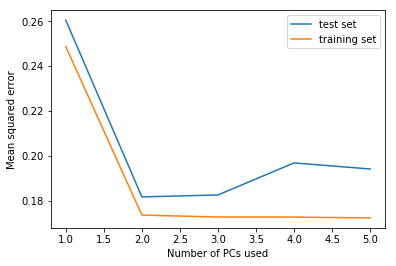

In [182]:
plt.plot(df_result.pc_i, df_result.mean_test_mse, label='test set')
plt.plot(df_result.pc_i, df_result.mean_train_mse, label='training set')
plt.xlabel('Number of PCs used')
plt.ylabel('Mean squared error')
plt.legend()
plt.show()

In [183]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression

X = new_df.iloc[:, 0:6]
y = new_df.iloc[:,7]

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2)

pca = PCA(n_components=2)
Xtrain = pca.fit_transform(Xtrain)
Xtest = pca.transform(Xtest)

model = LogisticRegression(random_state=1)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

conf_mat = confusion_matrix(ytest,ypred)
print('Controlled Data: PC Confusion matrix: \n', conf_mat)

pc_sensitivity_control = conf_mat[1,1]/(conf_mat[1,0] + conf_mat[1,1])
print('Sensitivity: ', pc_sensitivity_control)
pc_specificity_control = conf_mat[0,0]/(conf_mat[0,0] + conf_mat[0,1])
print('Specificity: ', pc_specificity_control)
pc_acc_control = (conf_mat[0,0]+conf_mat[1,1])/(conf_mat[0,0]+conf_mat[0,1]+conf_mat[1,0]+conf_mat[1,1])


print(pc_acc_control, '\n')
print('Accuracy:', pc_acc_control)

Controlled Data: PC Confusion matrix: 
 [[9 1]
 [3 9]]
Sensitivity:  0.75
Specificity:  0.9
0.818181818182 

Accuracy: 0.818181818182


# Results

In [102]:
df.Biopsy.sum() 

55

There are only 55 examples of cervical cancer patients.

With the controlled data (all 55 examples of cervical cancer patients and 55 examples of non-cervical cancer patients), the accuracy is lower than by using the whole set. There are  too few examples of patients with cervical cancer, so the models which use the whole dataset get a high accuracy of ~93% by classifying all patients with no cancer. Using the control set thus does a better classification job despite its lower accuracies.

In [202]:
Method = np.array(['Forward Selection whole data', 'Forward selection controlled data', 
                  'Principal Component Analysis whole data', 'Principal Component Analysis controlled data'])
Accuracy = np.array([fwd_acc_whole, fwd_acc_control, pc_acc_whole, pc_acc_control])

MSE = np.array([fwd_mse_whole, fwd_mse_control, pc_mse_whole, pc_mse_control])
Sensitivity = np.array([fwd_sensitivity_whole, fwd_sensitivity_control, pc_sensitivity_whole, pc_sensitivity_control])
Specificity = np.array([fwd_specificity_whole, fwd_specificity_control, pc_specificity_whole, pc_specificity_control])

final_df = []
final_df = ({'Method': Method, 'MSE': MSE, 
             'Accuracy': Accuracy,
                'Sensitivity': Sensitivity,
                'Specificity': Specificity})
final_df = pd.DataFrame(final_df)
final_df

,Accuracy,MSE,Method,Sensitivity,Specificity
0,0.937063,0.058662,Forward Selection whole data,0.054545,0.997509
1,0.818182,0.172670,Forward selection controlled data,0.727273,0.909091
2,0.934732,0.059188,Principal Component Analysis whole data,0.000000,0.998755
3,0.818182,0.181616,Principal Component Analysis controlled data,0.750000,0.900000
